In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, make_scorer

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping

# MLflow for model tracking
import mlflow
import mlflow.sklearn
import mlflow.lightgbm

# Garbage collection
import gc

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
import mlflow
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score   
from imblearn.under_sampling import RandomUnderSampler

from mlflow.tracking import MlflowClient

import gc
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import mlflow
import gc
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score
import numpy as np
import pandas as pd


import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt



In [2]:
def custom_cost_metric(y_true, y_pred, fn_cost=10, fp_cost=1):
    """
    Custom metric that calculates the total cost based on false negatives (FN) and false positives (FP).
    
    Parameters:
    - y_true: Array of true binary labels
    - y_pred: Array of predicted probabilities
    - fn_cost: Cost associated with false negatives
    - fp_cost: Cost associated with false positives

    Returns:
    - total_cost: The computed cost
    """
    y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    total_cost = fn * fn_cost + fp * fp_cost
    return total_cost

# Wrap the custom metric for use in sklearn
custom_cost_scorer = make_scorer(custom_cost_metric, fn_cost=10, fp_cost=1, greater_is_better=False)

def display_importances(feature_importance_df):
    """
    Function to display and save the feature importance plot.
    It assumes that feature importance data is passed as a DataFrame.
    """
    cols = (feature_importance_df[["feature", "importance"]]
            .groupby("feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:40].index)

    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
    plt.figure(figsize=(10, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


In [3]:
df=pd.read_csv('data/df_filled.csv')

In [6]:
df

REGION_RATING_CLIENT  PREV_NAME_GOODS_CATEGORY_OfficeAppliances_MEAN  \
0                          2                                             0.0   
1                          1                                             0.0   
2                          2                                             0.0   
3                          2                                             0.0   
4                          2                                             0.0   
...                      ...                                             ...   
356246                     3                                             0.0   
356247                     2                                             0.0   
356248                     2                                             0.0   
356249                     2                                             0.0   
356250                     2                                             0.0   

        REGION_RATING_CLIENT_W_CITY  \
0                                 2   
1                                 1   
2                                 2   
3                                 2   
4                                 2   
...                             ...   
356246                            3   
356247                            2   
356248                            2   
356249                            2   
356250                            2   

        PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN  \
0                                                0.000000   
1                                                0.333333   
2                                                0.000000   
3                                                0.000000   
4                                                0.000000   
...                                                   ...   
356246                                           0.000000   
356247                                           0.250000   
356248                                           0.000000   
356249                                           0.000000   
356250                                           0.000000   

        APPROVED_AMT_CREDIT_MEAN  APPROVED_AMT_APPLICATION_MEAN  \
0                    179055.0000                    179055.0000   
1                    484191.0000                    435436.5000   
2                     20106.0000                     24282.0000   
3                    343728.9000                    352265.8680   
4                    166638.7500                    150530.2500   
...                          ...                            ...   
356246               254700.0000                    225000.0000   
356247                98704.1250                     86871.3750   
356248               132516.8325                    141060.0825   
356249               247171.5000                    221418.0000   
356250               158396.6250                    153165.3750   

        PREV_PRODUCT_COMBINATION_CardStreet_MEAN  BURO_DAYS_CREDIT_MEAN  \
0                                       0.000000            -874.000000   
1                                       0.000000           -1400.750000   
2                                       0.000000            -867.000000   
3                                       0.111111           -1052.500000   
4                                       0.000000           -1149.000000   
...                                          ...                    ...   
356246                                  0.000000            -727.200000   
356247                                  0.000000           -1052.500000   
356248                                  0.000000            -539.000000   
356249                                  0.000000           -1755.823529   
356250                                  0.125000            -862.000000   

        PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN  OCCUPATION_TYPE_Corestaff  \
0                                              0.0        

In [4]:
df[df.drop('TARGET', axis=1).isna().any(axis=1)]

Empty DataFrame
Columns: [REGION_RATING_CLIENT, PREV_NAME_GOODS_CATEGORY_OfficeAppliances_MEAN, REGION_RATING_CLIENT_W_CITY, PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN, APPROVED_AMT_CREDIT_MEAN, APPROVED_AMT_APPLICATION_MEAN, PREV_PRODUCT_COMBINATION_CardStreet_MEAN, BURO_DAYS_CREDIT_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN, OCCUPATION_TYPE_Corestaff, BURO_AMT_CREDIT_SUM_MEAN, PREV_NAME_CLIENT_TYPE_nan_MEAN, INSTAL_DPD_SUM, APPROVED_HOUR_APPR_PROCESS_START_MIN, EMERGENCYSTATE_MODE_No, PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN, ORGANIZATION_TYPE_Electricity, WALLSMATERIAL_MODE_Monolithic, PREV_AMT_GOODS_PRICE_MIN, PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN, PREV_AMT_CREDIT_MEAN, BURO_CREDIT_ACTIVE_Baddebt_MEAN, FLAG_DOCUMENT_9, PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN, AMT_INCOME_TOTAL, POS_COUNT, PREV_NAME_CONTRACT_STATUS_Unusedoffer_MEAN, FLAG_DOCUMENT_10, APPROVED_AMT_DOWN_PAYMENT_MEAN, APPROVED_AMT_APPLICATION_MAX, OCCUPATION_TYPE_ITstaff, AMT_ANNUITY, WEEKDAY_APPR_PROCESS_START_SUNDAY, EMERGENCYSTATE_MODE_Yes, NAME_FAMILY_STATUS_Singlenotmarried, INSTAL_PAYMENT_DIFF_VAR, WALLSMATERIAL_MODE_Wooden, FONDKAPREMONT_MODE_notspecified, PREV_NAME_GOODS_CATEGORY_Insurance_MEAN, PREV_NAME_PORTFOLIO_XNA_MEAN, NAME_INCOME_TYPE_Student, ORGANIZATION_TYPE_Industrytype13, PREV_HOUR_APPR_PROCESS_START_MAX, PREV_CODE_REJECT_REASON_SYSTEM_MEAN, INSTAL_DBD_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN, ORGANIZATION_TYPE_Services, PREV_NAME_PRODUCT_TYPE_xsell_MEAN, BURO_CREDIT_TYPE_Anothertypeofloan_MEAN, PREV_DAYS_DECISION_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN, PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN, ORGANIZATION_TYPE_Industrytype10, NAME_FAMILY_STATUS_Married, PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN, ORGANIZATION_TYPE_Advertising, ORGANIZATION_TYPE_Tradetype5, DAYS_BIRTH, PREV_HOUR_APPR_PROCESS_START_MIN, ORGANIZATION_TYPE_Tradetype6, PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN, POS_SK_DPD_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN, NAME_HOUSING_TYPE_Houseapartment, PREV_CODE_REJECT_REASON_CLIENT_MEAN, PREV_NAME_GOODS_CATEGORY_Education_MEAN, ORGANIZATION_TYPE_Industrytype1, PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN, AMT_CREDIT, FLAG_EMP_PHONE, APPROVED_AMT_CREDIT_MIN, PREV_AMT_ANNUITY_MEAN, PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN, PREV_NAME_GOODS_CATEGORY_Furniture_MEAN, ORGANIZATION_TYPE_Industrytype2, APPROVED_AMT_GOODS_PRICE_MEAN, PREV_NAME_GOODS_CATEGORY_MedicalSupplies_MEAN, PREV_CODE_REJECT_REASON_SCOFR_MEAN, ORGANIZATION_TYPE_Industrytype3, ORGANIZATION_TYPE_BusinessEntityType1, NAME_EDUCATION_TYPE_Secondarysecondaryspecial, APPROVED_DAYS_DECISION_MAX, BURO_CREDIT_TYPE_Carloan_MEAN, NAME_HOUSING_TYPE_Officeapartment, ORGANIZATION_TYPE_Hotel, APPROVED_AMT_ANNUITY_MIN, ORGANIZATION_TYPE_Mobile, DAYS_ID_PUBLISH, ORGANIZATION_TYPE_Military, ORGANIZATION_TYPE_Tradetype1, PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN, INSTAL_DAYS_ENTRY_PAYMENT_MAX, PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN, HOUSETYPE_MODE_specifichousing, NAME_CONTRACT_TYPE_Revolvingloans, PREV_CODE_REJECT_REASON_SCO_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN, INSTAL_AMT_PAYMENT_SUM, OCCUPATION_TYPE_Realtyagents, POS_NAME_CONTRACT_STATUS_Canceled_MEAN, ...]
Index: []

[0 rows x 508 columns]

In [5]:
df[np.isinf(df).any(axis=1)]

Empty DataFrame
Columns: [REGION_RATING_CLIENT, PREV_NAME_GOODS_CATEGORY_OfficeAppliances_MEAN, REGION_RATING_CLIENT_W_CITY, PREV_NAME_GOODS_CATEGORY_ConsumerElectronics_MEAN, APPROVED_AMT_CREDIT_MEAN, APPROVED_AMT_APPLICATION_MEAN, PREV_PRODUCT_COMBINATION_CardStreet_MEAN, BURO_DAYS_CREDIT_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN, OCCUPATION_TYPE_Corestaff, BURO_AMT_CREDIT_SUM_MEAN, PREV_NAME_CLIENT_TYPE_nan_MEAN, INSTAL_DPD_SUM, APPROVED_HOUR_APPR_PROCESS_START_MIN, EMERGENCYSTATE_MODE_No, PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN, ORGANIZATION_TYPE_Electricity, WALLSMATERIAL_MODE_Monolithic, PREV_AMT_GOODS_PRICE_MIN, PREV_PRODUCT_COMBINATION_POSindustrywithinterest_MEAN, PREV_AMT_CREDIT_MEAN, BURO_CREDIT_ACTIVE_Baddebt_MEAN, FLAG_DOCUMENT_9, PREV_NAME_GOODS_CATEGORY_AutoAccessories_MEAN, AMT_INCOME_TOTAL, POS_COUNT, PREV_NAME_CONTRACT_STATUS_Unusedoffer_MEAN, FLAG_DOCUMENT_10, APPROVED_AMT_DOWN_PAYMENT_MEAN, APPROVED_AMT_APPLICATION_MAX, OCCUPATION_TYPE_ITstaff, AMT_ANNUITY, WEEKDAY_APPR_PROCESS_START_SUNDAY, EMERGENCYSTATE_MODE_Yes, NAME_FAMILY_STATUS_Singlenotmarried, INSTAL_PAYMENT_DIFF_VAR, WALLSMATERIAL_MODE_Wooden, FONDKAPREMONT_MODE_notspecified, PREV_NAME_GOODS_CATEGORY_Insurance_MEAN, PREV_NAME_PORTFOLIO_XNA_MEAN, NAME_INCOME_TYPE_Student, ORGANIZATION_TYPE_Industrytype13, PREV_HOUR_APPR_PROCESS_START_MAX, PREV_CODE_REJECT_REASON_SYSTEM_MEAN, INSTAL_DBD_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN, ORGANIZATION_TYPE_Services, PREV_NAME_PRODUCT_TYPE_xsell_MEAN, BURO_CREDIT_TYPE_Anothertypeofloan_MEAN, PREV_DAYS_DECISION_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Urgentneeds_MEAN, PREV_NAME_TYPE_SUITE_Groupofpeople_MEAN, ORGANIZATION_TYPE_Industrytype10, NAME_FAMILY_STATUS_Married, PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN, ORGANIZATION_TYPE_Advertising, ORGANIZATION_TYPE_Tradetype5, DAYS_BIRTH, PREV_HOUR_APPR_PROCESS_START_MIN, ORGANIZATION_TYPE_Tradetype6, PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN, POS_SK_DPD_MEAN, PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN, NAME_HOUSING_TYPE_Houseapartment, PREV_CODE_REJECT_REASON_CLIENT_MEAN, PREV_NAME_GOODS_CATEGORY_Education_MEAN, ORGANIZATION_TYPE_Industrytype1, PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN, AMT_CREDIT, FLAG_EMP_PHONE, APPROVED_AMT_CREDIT_MIN, PREV_AMT_ANNUITY_MEAN, PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN, PREV_NAME_GOODS_CATEGORY_Furniture_MEAN, ORGANIZATION_TYPE_Industrytype2, APPROVED_AMT_GOODS_PRICE_MEAN, PREV_NAME_GOODS_CATEGORY_MedicalSupplies_MEAN, PREV_CODE_REJECT_REASON_SCOFR_MEAN, ORGANIZATION_TYPE_Industrytype3, ORGANIZATION_TYPE_BusinessEntityType1, NAME_EDUCATION_TYPE_Secondarysecondaryspecial, APPROVED_DAYS_DECISION_MAX, BURO_CREDIT_TYPE_Carloan_MEAN, NAME_HOUSING_TYPE_Officeapartment, ORGANIZATION_TYPE_Hotel, APPROVED_AMT_ANNUITY_MIN, ORGANIZATION_TYPE_Mobile, DAYS_ID_PUBLISH, ORGANIZATION_TYPE_Military, ORGANIZATION_TYPE_Tradetype1, PREV_WEEKDAY_APPR_PROCESS_START_FRIDAY_MEAN, INSTAL_DAYS_ENTRY_PAYMENT_MAX, PREV_PRODUCT_COMBINATION_POSindustrywithoutinterest_MEAN, HOUSETYPE_MODE_specifichousing, NAME_CONTRACT_TYPE_Revolvingloans, PREV_CODE_REJECT_REASON_SCO_MEAN, PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN, INSTAL_AMT_PAYMENT_SUM, OCCUPATION_TYPE_Realtyagents, POS_NAME_CONTRACT_STATUS_Canceled_MEAN, ...]
Index: []

[0 rows x 508 columns]

In [17]:
# def data_completion_percentage(df, exclude_column='TARGET'):
#     # Drop the specified column(s) from the dataframe if they exist
#     df_excluded = df.drop(columns=[exclude_column], errors='ignore')
#     # Calculate completion percentage for the remaining columns
#     completion_percentage = df_excluded.notna().mean() * 100
#     return completion_percentage # Sort for easier viewing

# # Usage
# completion_percentage = data_completion_percentage(df)
# plt.plot(completion_percentage.sort_values(ascending=False) )

In [18]:
# def filter_columns_by_completion(df, completion_percentage, threshold=80, exclude_column='TARGET'):
#     # Keep 'TARGET' column if it exists, regardless of completion percentage
#     columns_to_keep = completion_percentage.index[completion_percentage >= threshold].tolist()
    
#     # Ensure 'TARGET' is always included if it's in the DataFrame
#     if exclude_column in df.columns:
#         columns_to_keep.append(exclude_column)
    
#     # Remove duplicates in case 'TARGET' was already in the list
#     columns_to_keep = list(set(columns_to_keep))
    
#     # Filter the DataFrame to include only the selected columns
#     df_cleaned = df[columns_to_keep]
    
#     return df_cleaned

# df_cleaned = filter_columns_by_completion(df, completion_percentage)

In [19]:
# def fill_nans_with_median_except_target(df, target_column='TARGET'):
#     # Select columns to fill (excluding the target column)
#     columns_to_fill = df.columns[df.columns != target_column]
    
#     # Fill NaN values with the median for all columns except the target
#     df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].median())
    
#     return df

# # Usage
# df_filled = fill_nans_with_median_except_target(df_cleaned)

# Log Reg classifier

In [7]:
def kfold_logreg(df, num_folds):
    # Define Logistic Regression parameters
    logreg_params = {
        'max_iter': 1000,
        'solver': 'liblinear',
        'penalty': 'l2',
        'C': 1.0
    }

    # Log parameters to MLflow
    for param, value in logreg_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    train_df = train_df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    train_df = train_df.dropna()  # Drop rows with NaN (or fill them as appropriate)
    test_df = df[df['TARGET'].isnull()]
    test_df = test_df.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
    test_df = test_df.dropna(subset=[col for col in df.columns if col != 'TARGET'])  # Drop rows with NaN (or fill them as appropriate)
    print(f"Starting Logistic Regression. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['TARGET']),
        y=train_df['TARGET']
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Set sample_weight to balance classes during training
        sample_weight = train_y.map(class_weights_dict)

        clf = LogisticRegression(**logreg_params)
        clf.fit(train_x, train_y, sample_weight=sample_weight)

        oof_preds[valid_idx] = clf.predict_proba(valid_x)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats])[:, 1] / folds.n_splits
        

        # Log metrics for the fold
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))

        # Log custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)

        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.sklearn.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)

    # Log full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)


In [8]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name="Logistic regression"):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "Logistic regression")
    
    logreg = kfold_logreg(df, num_folds= 3)

Starting Logistic Regression. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1


2024/12/03 15:19:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2


2024/12/03 15:23:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3


2024/12/03 15:27:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic regression at: http://127.0.0.1:5000/#/experiments/0/runs/f96568b7e8f44b6186f713d6ef2b208d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [9]:
del logreg

# lgb no weight

In [40]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

Starting LightGBM. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45280
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080072 -> initscore=-2.441374
[LightGBM] [Info] Start training from score -2.441374
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

2024/12/03 15:55:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[LightGBM] [Info] Number of positive: 16697, number of negative: 188308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.496009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45354
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081447 -> initscore=-2.422850
[LightGBM] [Info] Start training from score -2.422850
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024/12/03 15:57:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[LightGBM] [Info] Number of positive: 16538, number of negative: 188467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.435034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45271
[LightGBM] [Info] Number of data points in the train set: 205005, number of used features: 462
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080671 -> initscore=-2.433262
[LightGBM] [Info] Start training from score -2.433262
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

2024/12/03 15:58:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LightGBM no weight'.
2024/12/03 15:59:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM no weight, version 1
Created version '1' of model 'LightGBM no weight'.


🏃 View run LightGBM no weight at: http://127.0.0.1:5000/#/experiments/0/runs/011d459e312b42ed8a81ada235d30e20
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


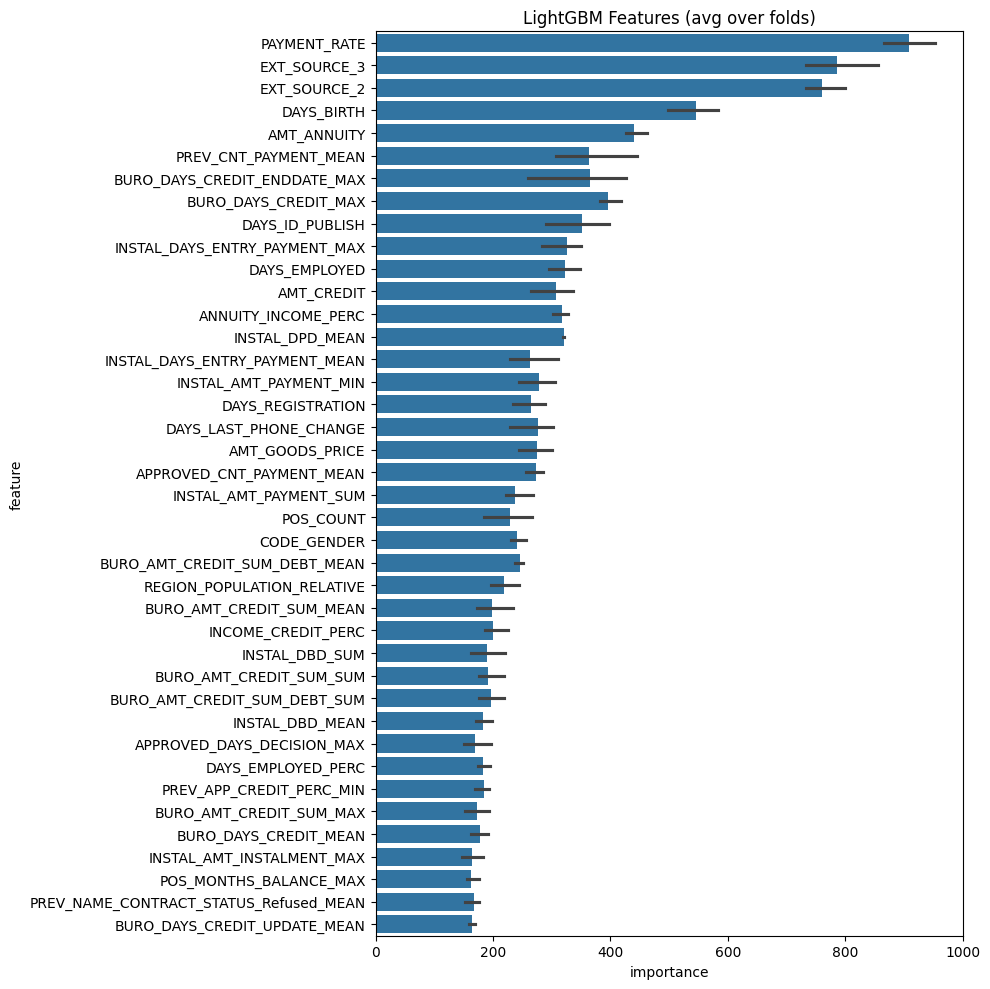

In [41]:
from mlflow.tracking import MlflowClient
name="LightGBM no weight"
descriptions="LightGBM model trained , using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=descriptions
    )

# data imbalanced

## class weight

In [18]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    # Compute class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['TARGET']),
        y=train_df['TARGET']
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Set sample_weight to balance classes during training
        sample_weight = train_y.map(class_weights_dict)

        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                sample_weight=sample_weight,  # Add class weights
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

        


In [19]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name="LightGBM sklearnclass_weight"):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)

Starting LightGBM. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.343853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45280
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 465
🏃 View run LightGBM sklearnclass_weight at: http://127.0.0.1:5000/#/experiments/0/runs/d02f2770833f4217bb43d37b89831cc1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


KeyboardInterrupt: 

In [13]:
del feat_importance

## SMOTE and random under sampling

In [24]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")
    
    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    rus = RandomUnderSampler(random_state=42)  # Initialize RandomUnderSampler

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # Count the number of samples in each class
        n_minority = np.sum(train_y == 1)
        n_majority = np.sum(train_y == 0)

        # Define SMOTE with a 25% increase in the minority class
        print(len(train_x),len(train_y))
        smote_strategy = (n_minority + 0.5 * n_minority) / n_majority
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        train_x_res, train_y_res = smote.fit_resample(train_x, train_y)
        print("after SMOTE",len(train_x_res),len(train_y_res))       

        
        # Apply Random Under Sampling after SMOTE
        train_x_res, train_y_res = rus.fit_resample(train_x_res, train_y_res)
        print("after RUS", len(train_x_res),len(train_y_res))

        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x_res, train_y_res,
                eval_set=[(train_x_res, train_y_res), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx])
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x_res, train_y_res, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')



Starting LightGBM. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1
205004 205004
after SMOTE 213211 213211
after RUS 49244 49244
[LightGBM] [Info] Number of positive: 24622, number of negative: 24622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64157
[LightGBM] [Info] Number of data points in the train set: 49244, number of used features: 448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

2024/12/03 15:35:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
205005 205005
after SMOTE 213353 213353
after RUS 50090 50090
[LightGBM] [Info] Number of positive: 25045, number of negative: 25045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64256
[LightGBM] [Info] Number of data points in the train set: 50090, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

2024/12/03 15:36:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
205005 205005
after SMOTE 213274 213274
after RUS 49614 49614
[LightGBM] [Info] Number of positive: 24807, number of negative: 24807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64241
[LightGBM] [Info] Number of data points in the train set: 49614, number of used features: 448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

2024/12/03 15:37:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'LightGBM with SMOTE and RUS' already exists. Creating a new version of this model...
2024/12/03 15:37:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM with SMOTE and RUS, version 5
Created version '5' of model 'LightGBM with SMOTE and RUS'.


🏃 View run LightGBM with SMOTE and RUS at: http://127.0.0.1:5000/#/experiments/0/runs/172d9c5150c74857b83f986abc2c9b96
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


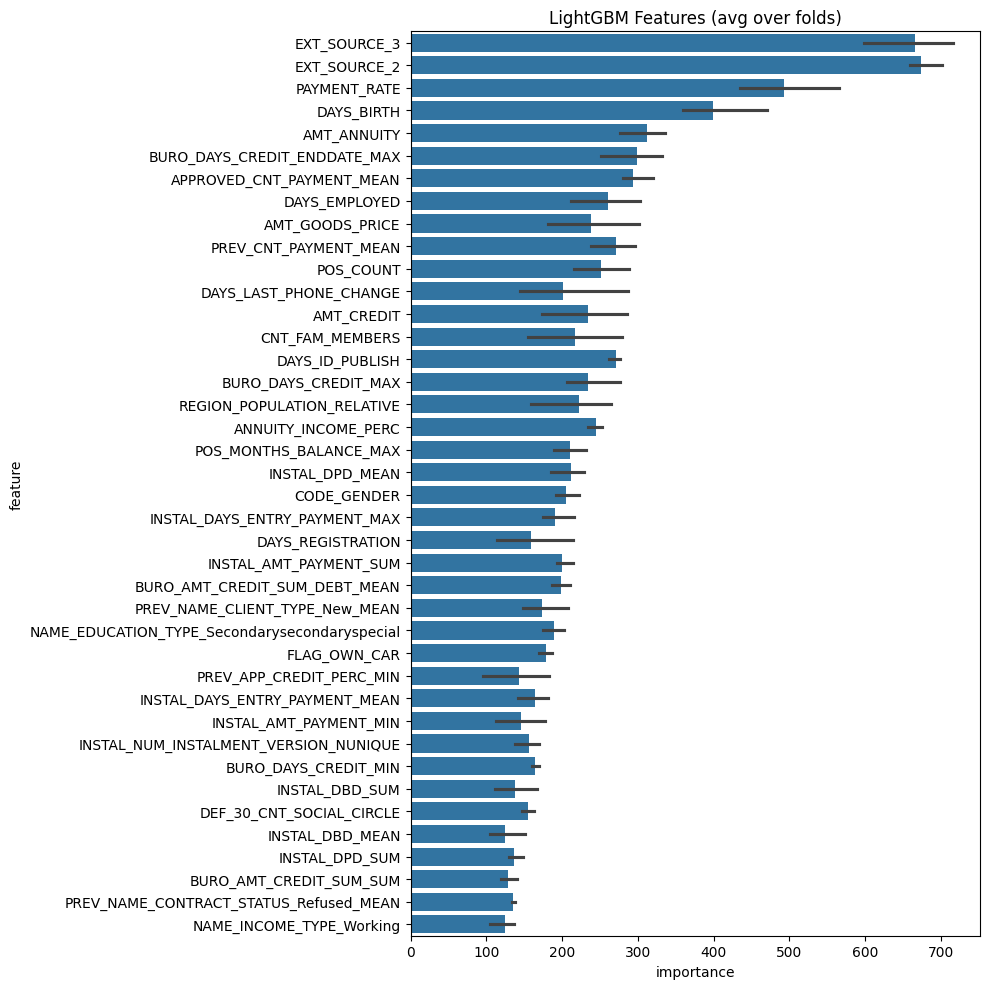

In [25]:
name="LightGBM with SMOTE and RUS"
description="LightGBM model trained with SMOTE and RandomUnderSampler"


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM with SMOTE and RUS")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=description
    )

In [26]:
del feat_importance

# class_weight lightgbm

In [27]:
weight=282682/24825
df['TARGET'].value_counts()
weight

11.386988922457201

In [4]:
def kfold_lightgbm(df, num_folds):
    # Define your parameters and log them with MLflow
    lgb_params = {
        'class_weight':'balanced',
        #'scale_pos_weight':weight,
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775
    }

    # Log all parameters to MLflow
    for param, value in lgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]


    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]


        clf = LGBMClassifier(**lgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.lightgbm.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('lgbm_importances01.png')

In [5]:

name="LightGBM with class_weight balanced"
descriptions="LightGBM model trained with class_weight balanced, using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "LightGBM_kfold_3")
    
    feat_importance = kfold_lightgbm(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=descriptions
    )

Starting LightGBM. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1
[LightGBM] [Info] Number of positive: 16415, number of negative: 188589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.622905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45280
[LightGBM] [Info] Number of data points in the train set: 205004, number of used features: 465
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 10 rounds
🏃 View run LightGBM with class_weight balanced at: http://127.0.0.1:5000/#/experiments/0/runs/84a04c1e029d4d5eb89c1257c74e7d41
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


KeyboardInterrupt: 

# XGB 

In [53]:
def kfold_xgboost(df, num_folds):
    
    # Define parameters for XGBoost
    xgb_params = {'scale_pos_weight':weight,
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'max_depth': 8,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_child_weight': 39.3259775,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'early_stopping_rounds' :3,
    }

    # Log all parameters to MLflow
    for param, value in xgb_params.items():
        mlflow.log_param(param, value)

    train_df = df[df['TARGET'].notnull()]
    
    test_df = df[df['TARGET'].isnull()]
    print(f"Starting XGBoost. Train shape: {train_df.shape}, test shape: {test_df.shape}")

    del df
    gc.collect()

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print(f"Fold {n_fold + 1}")

        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                verbose=True)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, iteration_range=(0, clf.best_iteration))[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], iteration_range=(0, clf.best_iteration))[:, 1] / folds.n_splits


        # Collect feature importances
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        # Calculate and print metrics
        fold_auc = roc_auc_score(valid_y, oof_preds[valid_idx])
        fold_f1 = f1_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_recall = recall_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        fold_precision = precision_score(valid_y, (oof_preds[valid_idx] > 0.5).astype(int))
        
        # Calculate custom cost
        fold_custom_cost = custom_cost_metric(valid_y, oof_preds[valid_idx], fn_cost=10, fp_cost=1)
        
        # Log metrics to MLflow
        mlflow.log_metric(f'fold_{n_fold + 1}_auc', fold_auc)
        mlflow.log_metric(f'fold_{n_fold + 1}_f1', fold_f1)
        mlflow.log_metric(f'fold_{n_fold + 1}_recall', fold_recall)
        mlflow.log_metric(f'fold_{n_fold + 1}_precision', fold_precision)
        mlflow.log_metric(f'fold_{n_fold + 1}_custom_cost', fold_custom_cost)

        # Log the model for the current fold
        mlflow.xgboost.log_model(clf, f'model_fold_{n_fold + 1}')

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Calculate and log overall metrics
    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    full_accuracy = accuracy_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_f1 = f1_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_recall = recall_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_precision = precision_score(train_df['TARGET'], (oof_preds > 0.5).astype(int))
    full_custom_cost = custom_cost_metric(train_df['TARGET'], oof_preds)
    
    # Log the full metrics to MLflow
    mlflow.log_metric('full_auc', full_auc)
    mlflow.log_metric('full_accuracy', full_accuracy)
    mlflow.log_metric('full_f1', full_f1)
    mlflow.log_metric('full_recall', full_recall)
    mlflow.log_metric('full_precision', full_precision)
    mlflow.log_metric('full_custom_cost', full_custom_cost)

    # Log feature importance plot as an artifact
    display_importances(feature_importance_df)
    mlflow.log_artifact('xgb_importances01.png')


Starting XGBoost. Train shape: (307507, 508), test shape: (48744, 508)
Fold 1
[0]	validation_0-auc:0.74907	validation_1-auc:0.70278
[1]	validation_0-auc:0.76559	validation_1-auc:0.71725
[2]	validation_0-auc:0.77262	validation_1-auc:0.72447
[3]	validation_0-auc:0.77646	validation_1-auc:0.72895
[4]	validation_0-auc:0.77822	validation_1-auc:0.73113
[5]	validation_0-auc:0.77994	validation_1-auc:0.73275
[6]	validation_0-auc:0.78180	validation_1-auc:0.73390
[7]	validation_0-auc:0.78354	validation_1-auc:0.73490
[8]	validation_0-auc:0.78438	validation_1-auc:0.73554
[9]	validation_0-auc:0.78574	validation_1-auc:0.73625
[10]	validation_0-auc:0.78677	validation_1-auc:0.73705
[11]	validation_0-auc:0.78775	validation_1-auc:0.73760
[12]	validation_0-auc:0.78872	validation_1-auc:0.73810
[13]	validation_0-auc:0.78950	validation_1-auc:0.73853
[14]	validation_0-auc:0.79055	validation_1-auc:0.73890
[15]	validation_0-auc:0.79185	validation_1-auc:0.73938
[16]	validation_0-auc:0.79261	validation_1-auc:0.740

2024/12/03 16:32:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 2
[0]	validation_0-auc:0.74798	validation_1-auc:0.70172
[1]	validation_0-auc:0.76539	validation_1-auc:0.71853
[2]	validation_0-auc:0.77199	validation_1-auc:0.72501
[3]	validation_0-auc:0.77624	validation_1-auc:0.72671
[4]	validation_0-auc:0.77918	validation_1-auc:0.72873
[5]	validation_0-auc:0.78078	validation_1-auc:0.73018
[6]	validation_0-auc:0.78243	validation_1-auc:0.73204
[7]	validation_0-auc:0.78422	validation_1-auc:0.73291
[8]	validation_0-auc:0.78544	validation_1-auc:0.73389
[9]	validation_0-auc:0.78651	validation_1-auc:0.73495
[10]	validation_0-auc:0.78799	validation_1-auc:0.73581
[11]	validation_0-auc:0.78883	validation_1-auc:0.73643
[12]	validation_0-auc:0.78962	validation_1-auc:0.73697
[13]	validation_0-auc:0.79017	validation_1-auc:0.73735
[14]	validation_0-auc:0.79090	validation_1-auc:0.73772
[15]	validation_0-auc:0.79138	validation_1-auc:0.73830
[16]	validation_0-auc:0.79220	validation_1-auc:0.73894
[17]	validation_0-auc:0.79276	validation_1-auc:0.73945
[18]	validati

2024/12/03 16:37:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fold 3
[0]	validation_0-auc:0.74911	validation_1-auc:0.70547
[1]	validation_0-auc:0.76582	validation_1-auc:0.72003
[2]	validation_0-auc:0.77206	validation_1-auc:0.72567
[3]	validation_0-auc:0.77541	validation_1-auc:0.72844
[4]	validation_0-auc:0.77735	validation_1-auc:0.73064
[5]	validation_0-auc:0.77910	validation_1-auc:0.73152
[6]	validation_0-auc:0.78123	validation_1-auc:0.73281
[7]	validation_0-auc:0.78268	validation_1-auc:0.73349
[8]	validation_0-auc:0.78405	validation_1-auc:0.73436
[9]	validation_0-auc:0.78525	validation_1-auc:0.73479
[10]	validation_0-auc:0.78615	validation_1-auc:0.73518
[11]	validation_0-auc:0.78702	validation_1-auc:0.73597
[12]	validation_0-auc:0.78806	validation_1-auc:0.73680
[13]	validation_0-auc:0.78915	validation_1-auc:0.73758
[14]	validation_0-auc:0.79017	validation_1-auc:0.73836
[15]	validation_0-auc:0.79126	validation_1-auc:0.73867
[16]	validation_0-auc:0.79190	validation_1-auc:0.73910
[17]	validation_0-auc:0.79277	validation_1-auc:0.73993
[18]	validati

2024/12/03 16:40:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost with class_weight at: http://127.0.0.1:5000/#/experiments/0/runs/4a4d1a767c4647fa9136516c92d9f8d1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


FileNotFoundError: [Errno 2] No such file or directory: 'xgb_importances01.png'

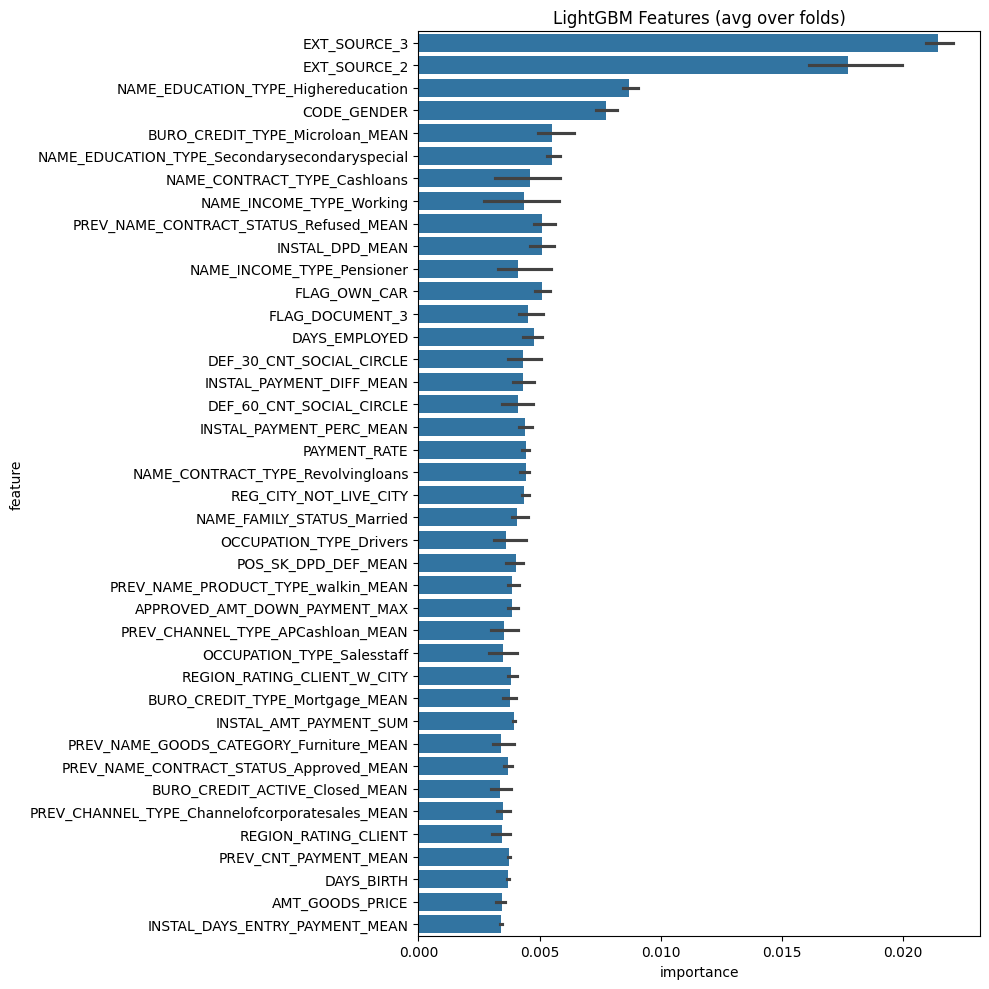

In [54]:
from mlflow.tracking import MlflowClient
name="XGBoost with class_weight"
description="XGBoost model trained with class_weight, using 3-fold cross-validation."


mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.end_run()
with mlflow.start_run(run_name=name):
    # Add experiment name and tags
    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "XGB_kfold_3")
    
    feat_importance = kfold_xgboost(df, num_folds= 3)
    
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
    model_version = mlflow.register_model(model_uri, name)
    client = MlflowClient()
    
    client.update_model_version(
        name=name,
        version=model_version.version,
        description=description
    )

# Model selected : Lightgbm with class_weight balanced

## Grid search

In [7]:
# Define your initial parameters
base_params = {
    'class_weight': 'balanced',
    'nthread': 4,
    'num_leaves': 34,
    'colsample_bytree': 0.9497036,
    'subsample': 0.8715623,
    'reg_alpha': 0.041545473,
    'reg_lambda': 0.0735294,
    'min_split_gain': 0.0222415,
    'min_child_weight': 39.3259775,
    'n_estimators': 5000,
}

param_grid = {
    'max_depth': [6, 8],
    'learning_rate': [0.02, 0.05]
}    

# Split data into train and test
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print(f"Starting LightGBM with GridSearch. Train shape: {train_df.shape}, test shape: {test_df.shape}")
df_sampled, _ = train_test_split(train_df, test_size=0.8, stratify=train_df['TARGET'], random_state=42)
print(f"Starting LightGBM with GridSearch. Sample shape: {df_sampled.shape}, test shape: {test_df.shape}")

feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
    
# Initialize the LightGBM classifier
clf = LGBMClassifier(**base_params)

# Define the grid search
grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='roc_auc', verbose=10,n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(df_sampled[feats], df_sampled['TARGET'])

print(f"Best score found: {grid_search.best_score_}")
print(f"Best parameters found: {grid_search.best_params_}")


Starting LightGBM with GridSearch. Train shape: (307507, 508), test shape: (48744, 508)
Starting LightGBM with GridSearch. Sample shape: (61501, 508), test shape: (48744, 508)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 2/2; 1/4] START learning_rate=0.02, max_depth=6.............................[CV 1/2; 4/4] START learning_rate=0.05, max_depth=8.............................
[CV 1/2; 3/4] START learning_rate=0.05, max_depth=6.............................
[CV 1/2; 2/4] START learning_rate=0.02, max_depth=8.............................
[CV 2/2; 2/4] START learning_rate=0.02, max_depth=8.............................

[CV 2/2; 4/4] START learning_rate=0.05, max_depth=8.............................
[CV 2/2; 3/4] START learning_rate=0.05, max_depth=6.............................
[CV 1/2; 1/4] START learning_rate=0.02, max_depth=6.............................
[LightGBM] [Info] Number of positive: 2482, number of negative: 28268
[LightGBM] [Info] Number of positive: 2483, num

# Save the model

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.550721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45303
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

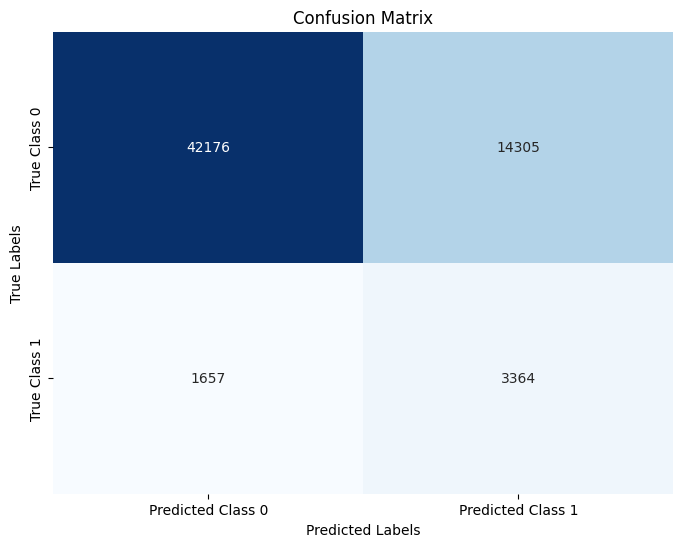

In [4]:
df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
train_x, train_y = train_df[feats], train_df['TARGET']
test_x, test_y = test_df[feats], test_df['TARGET']

X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Train LightGBM with training data
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)


params = {'class_weight':'balanced',
        'nthread': 4,
        'n_estimators': 10000,
        'learning_rate': 0.02,
        'num_leaves': 34,
        'colsample_bytree': 0.9497036,
        'subsample': 0.8715623,
        'max_depth': 8,
        'reg_alpha': 0.041545473,
        'reg_lambda': 0.0735294,
        'min_split_gain': 0.0222415,
        'min_child_weight': 39.3259775,
        'early_stopping_round' : 10,
    }

model = LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='auc'
)

# Evaluate on validation set
y_pred = model.predict(X_valid)
print("Accuracy on validation set:", accuracy_score(y_valid, y_pred))
print("Roc Auc score on validation set:", roc_auc_score(y_valid, y_pred))
print("F1 score on validation set:", f1_score(y_valid, y_pred))
print("Custom cost metric score on validation set:", custom_cost_metric(y_valid, y_pred))

cm = confusion_matrix(y_valid, y_pred)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Class 0', 'Predicted Class 1'], 
            yticklabels=['True Class 0', 'True Class 1'])

# Titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [9]:
from sklearn.metrics import classification_report

# Generate classification report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56481
         1.0       0.19      0.67      0.30      5021

    accuracy                           0.74     61502
   macro avg       0.58      0.71      0.57     61502
weighted avg       0.90      0.74      0.80     61502



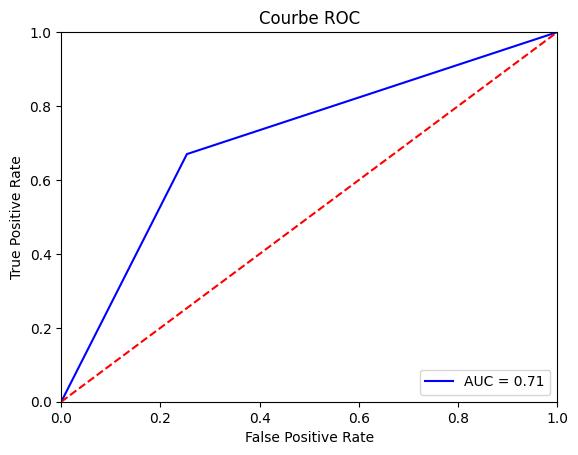

In [10]:
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Courbe ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
# Define the function to evaluate metrics at different thresholds
def evaluate_thresholds(model, X_valid, y_valid, thresholds=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    y_probs = model.predict_proba(X_valid)  # Get predicted probabilities
    results = []

    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        print
        y_pred = (y_probs[:, 1] > threshold).astype(int)
        
        # Evaluate the model performance at this threshold
        accuracy = accuracy_score(y_valid, y_pred)
        roc_auc = roc_auc_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        custom_cost = custom_cost_metric(y_valid, y_pred)  # Use your custom cost metric

        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'f1_score': f1,
            'custom_cost_metric': custom_cost
        })

    # Convert results to a DataFrame for easy comparison
    results_df = pd.DataFrame(results)
    return results_df

# Now call the function to evaluate thresholds
results_df = evaluate_thresholds(model, X_valid, y_valid, thresholds=np.arange(0.40, 0.60, 0.01).tolist())

# Show the results
print(results_df)

# You can choose the threshold with the best performance in terms of your desired metric (e.g., F1 score or custom cost metric)
best_threshold = results_df.loc[results_df['custom_cost_metric'].idxmin()]['threshold']
print("Best threshold based on F1 score:", best_threshold)

    threshold  accuracy   roc_auc  f1_score  custom_cost_metric
0        0.40  0.633394  0.699511  0.257467               32555
1        0.41  0.644760  0.701435  0.261193               32279
2        0.42  0.656483  0.702918  0.264969               32044
3        0.43  0.667263  0.704069  0.268516               31849
4        0.44  0.678970  0.705544  0.272727               31615
5        0.45  0.689831  0.705651  0.276108               31523
6        0.46  0.700465  0.706269  0.279941               31382
7        0.47  0.710741  0.707508  0.284277               31182
8        0.48  0.721554  0.708496  0.288917               31003
9        0.49  0.731114  0.708711  0.292837               30910
10       0.50  0.740464  0.708358  0.296518               30875
11       0.51  0.749472  0.706729  0.299382               30969
12       0.52  0.759374  0.707403  0.304526               30828
13       0.53  0.767731  0.705783  0.307528               30926
14       0.54  0.776154  0.705379  0.311

In [12]:
name="LightGBM_final"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
with mlflow.start_run(run_name=name):

    mlflow.set_tag("developer", "Elise")
    mlflow.set_tag("experiment", "final")
    mlflow.lightgbm.log_model(model, "lightgbm_model_final")
    mlflow.log_metric("accuracy", accuracy_score(y_valid, y_pred))
    print(f"Modèle enregistré dans MLflow avec ID de run: {mlflow.active_run().info.run_id}")
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"


2024/12/04 00:43:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle enregistré dans MLflow avec ID de run: f18925492b974af4aaae5fe4d38cd151
🏃 View run LightGBM_final at: http://127.0.0.1:5000/#/experiments/0/runs/f18925492b974af4aaae5fe4d38cd151
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


# global importance

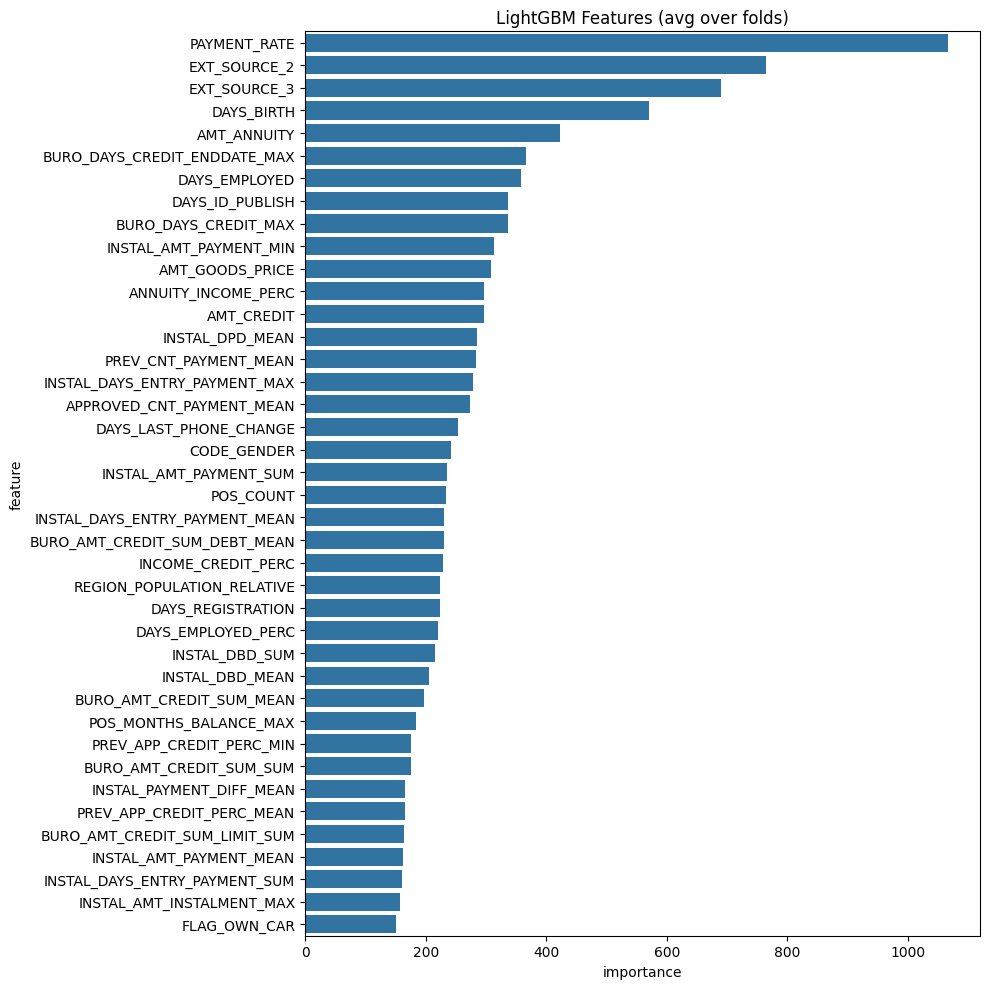

In [13]:
feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']] 
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = feats
feature_importance_df["importance"] = model.feature_importances_
display_importances(feature_importance_df)

# local importance

In [14]:
y_valid

232923    0.0
263698    0.0
36463     0.0
279380    0.0
148324    0.0
         ... 
128155    0.0
303642    0.0
93076     0.0
250504    1.0
10118     0.0
Name: TARGET, Length: 61502, dtype: float64

In [6]:
# Retrieve the specific client's data 
client_id = 263698    
client_data = X_valid.loc[X_valid.index == client_id]

# If SK_ID_CURR isn't in the features, use the index or another identifier
if client_data.empty:
    print(f"Client {client_id} not found in the test set.")
else:
    # Convert data to numpy array for LIME
    client_data_np = client_data.values

    # LIME explainer expects data in its original form (before one-hot encoding, if applicable)
    # If train_x is already preprocessed, we use it directly
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feats,
        class_names=['Not Default', 'Default'],
        mode='classification'
    )

    # Predict function must be a probability output
    def predict_fn(data):
        return model.predict_proba(data)

    # Explain prediction for the client
    explanation = explainer.explain_instance(
        data_row=client_data_np[0],  # Single client's feature vector
        predict_fn=predict_fn,
        num_features=10  # Number of top features to show
    )

    # Display explanation
    explanation.show_in_notebook() 

In [9]:
# Retrieve the specific client's data 
client_id = 250504        
client_data = X_valid.loc[X_valid.index == client_id]

# If SK_ID_CURR isn't in the features, use the index or another identifier
if client_data.empty:
    print(f"Client {client_id} not found in the test set.")
else:
    # Convert data to numpy array for LIME
    client_data_np = client_data.values

    # LIME explainer expects data in its original form (before one-hot encoding, if applicable)
    # If train_x is already preprocessed, we use it directly
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feats,
        class_names=['Not Default', 'Default'],
        mode='classification'
    )

    # Predict function must be a probability output
    def predict_fn(data):
        return model.predict_proba(data)

    # Explain prediction for the client
    explanation = explainer.explain_instance(
        data_row=client_data_np[0],  # Single client's feature vector
        predict_fn=predict_fn,
        num_features=10  # Number of top features to show
    )

    # Display explanation
    explanation.show_in_notebook() 

In [8]:
client_data.to_csv('client_data.csv')